Ultimate Technologies Challenge 

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Part 1: Exploratory Data Analysis -- User Login Counts

In [2]:
#Load json into pandas
logins_df = pd.read_json('logins.json')

#Convert data to datatime --if not already
if logins_df['login_time'].dtype != '<M8[ns]':
    logins_df['login_time'] = pd.to_datetime(logins_df['login_time'])

#Set datetime as index column
logins_df.set_index('login_time', inplace=True)
logins_df = logins_df.resample('15T').count()
logins_df['day'] = logins_df.index.day
logins_df['month'] = logins_df.index.month
logins_df['hour'] = logins_df.index.hour
logins_df['minute'] = logins_df.index.minute

def count(series):
    return series.count()

logins_df['daily_logins'] = logins_df.groupby(['month', 'day'])['day'].transform(count)
logins_df.groupby(['month', 'day'])['daily_logins'].count()
#logins_df[(logins_df['day']==20)&(logins_df['month']==1)]['daily_logins']
#logins_df

month  day
1      1      16
       2      96
       3      96
       4      96
       5      96
              ..
4      9      96
       10     96
       11     96
       12     96
       13     76
Name: daily_logins, Length: 103, dtype: int64

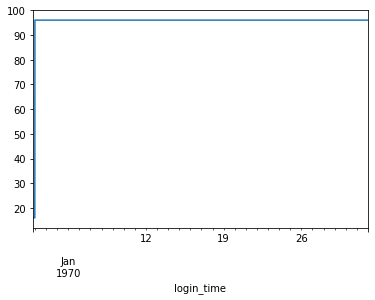

In [3]:
logins_df.loc['1970-01-01':'1970-01-31', 'daily_logins'].plot()
plt.show()

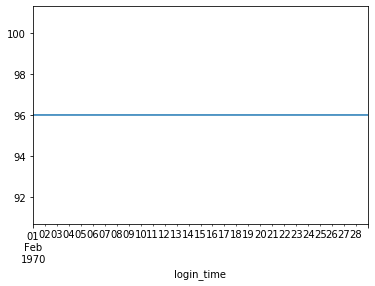

In [4]:
logins_df.loc['1970-02-01':'1970-02-28', 'daily_logins'].plot()
plt.show()

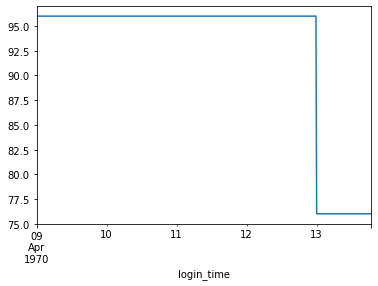

In [5]:
logins_df.loc['1970-04-09':'1970-04-13', 'daily_logins'].plot()
plt.show()

Visualizing daily logins for the months of January, February and part of April sampled every 15 minutes, we can see that login counts started low in the beginning then steadied over the next two months. This is probably not an accurate representation of user activity since the downsampling to 15 minutes turned out as a coarse attempt of whitening the data. A following suggestion would be to visualize more samples that could show finer trends in user activity through that period.

Part 2: Experiment and metrics design -- Reimbursing Toll Costs

Since both cities have exclusive driver partners and complementary rhythms on weekdays, it would be appropriate to measure the change in the average number of each city's active driver partners before and after implementing the toll reimbursement change.

To design the experiment, assuming we already have methods of measuring driver activity, we could utilize existing data before implementing the change and plot the distribution of average driver activity in each city during weekdays. We would then implement the change and measure the new activity, plot the new mean distribution of activity. We would then use a statistical t-test to determine whether there was a significant change in both means, before and after the change. If there was a significant change, we could reject our null hypothesis that reimbursing the toll costs won't have any change on driver partner activities in both cities on weekdays. We would start implmenting the change for a trial period and repeat the experiment at a determined future time. If there wasn't a significant change, we could conclude that there are other factors causing this exclusive driver activity whether it is increasing fuel or car maintenance costs that affect driver income more than toll costs.

We could also repeat the experiment on weekends and measure the change in means. If there wasn't a significant change, this would increase our affirmation that toll costs are not that troublesome. However, if there was an increase in activity, this could suggest that more driver partners are utilizing the new reimbursement feature and increasing their cross-city trips.

Part 3: Predictive Modeling -- Rider Retention

In [6]:
with open('ultimate_data_challenge.json') as data_file:
    data = json.load(data_file)

#Get keys first
keys_list = list(data[0].keys())

#Get values second with a list of values for each key
values_list = []
for key in keys_list:
    key_values_list = []
    for item in data:
        key_values_list.append(item[key])
    values_list.append(key_values_list)

#Create dataframe
zipped = zip(keys_list, values_list)
data_df = pd.DataFrame(dict(zipped))
data_df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


The data are over a span of 6 months from January to June 2014. Assuming the data were pulled on the last recorded day a user took a trip; we can calculate the number of users who took a trip in the month preceding to find the number of retained users.

In [7]:
from datetime import timedelta

diff = timedelta(days=30)

In [8]:
#Convert datetime to timestamps
data_df['last_trip_date'] = pd.to_datetime(data_df['last_trip_date'])
curr_date = pd.to_datetime(max(data_df['last_trip_date']))
start_date = curr_date - diff

#Find users who took a trip between start_date and curr_date
d_after = data_df['last_trip_date'] > start_date
d_before = data_df['last_trip_date'] < curr_date
num_retained = len(data_df[d_after & d_before].index)
num_users = len(data_df.index)
print('The percentage of retained users was {}%'.format(num_retained/num_users * 100))

The percentage of retained users was 35.524%


In [9]:
data_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


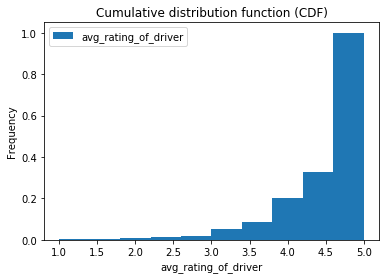

In [49]:
data_df.plot(y='avg_rating_of_driver', kind='hist', cumulative=True, density=True)
plt.xlabel('avg_rating_of_driver') 
plt.title('Cumulative distribution function (CDF)')
plt.show()

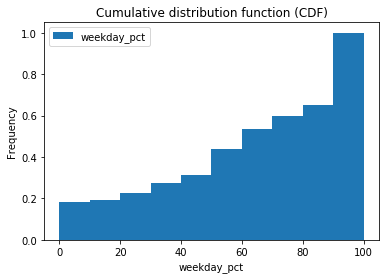

In [11]:
data_df.plot(y='weekday_pct', kind='hist', cumulative=True, normed=True)
plt.xlabel('weekday_pct') 
plt.title('Cumulative distribution function (CDF)')
plt.show()

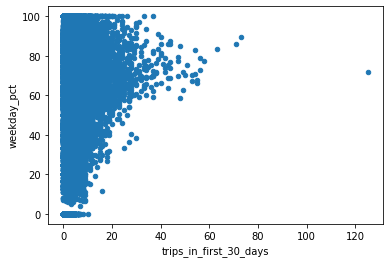

In [12]:
data_df.plot(x='trips_in_first_30_days', y='weekday_pct',kind='scatter')
plt.xlabel('trips_in_first_30_days')
plt.ylabel('weekday_pct')
plt.show()

To build a predictive model, we will start with exploring the relationship between the existing users' number of trips in the first 30 days after signing up for the service and the number of days between their signup date and the date of their last recorded trip. We will assume there's a direct linear correlation between the number of trips and the difference in days. In other words, it is presumed that as the number of trips the user took in the first 30 days increases, the difference between his first and last trip increases. This would suggest the user's need for the service rather than it being a trial signup, on the other hand, it could also suggest the user's satisfaction with the service and him being a regular user in the future; if the frequency of the user's trips is high and the difference between his first and last trip is high, we could predict him to still use the services in the future.

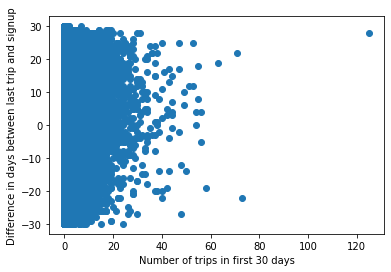

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

data_df['signup_date'] = pd.to_datetime(data_df['signup_date'])
data_df['signup_day'] = data_df['signup_date'].dt.day
data_df['last_trip_day'] = data_df['last_trip_date'].dt.day
diff_day = pd.to_timedelta(data_df['last_trip_day'] - data_df['signup_day'])

#Build the regression model
X = data_df['trips_in_first_30_days'].astype("int64").values.reshape(-1, 1)
y = diff_day.astype("int64").values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

plt.scatter(X, y)
plt.xlabel('Number of trips in first 30 days') 
plt.ylabel('Difference in days between last trip and signup') 
plt.show()

reg = LinearRegression(normalize=True) 
reg.fit(X_train, y_train)

In [48]:
y_pred = reg.predict(X_test) 
reg.score(X_test, y_test)

0.003468101485735064

The scatter plot between the variables suggests that the relationship between the variables is not directly linear and there are most likely other factors we should include in the model.

To predict whether a new user will be active in their sixth month after signup, it would be helpful to determine past user circumstances and behavior and use those factors in predicting new user behavior. Other features to consider would be to add the average rating of driver to the model and continue with multi-linear regression. Linear regression assumptions might not be fully satisfied or the data is innately too non-linear for such a model.